# Seasonality Analysis

Seasonality refers to regular and predictable variations or patterns in a time series that occur at certain time intervals such as daily, weekly or yearly.

My main goal is to identify significant trends, seasonal patterns and residuals in products. Using advanced statistical analysis and visualization tools to analyze and interpret the temporal dynamics of the dataset

### Imports

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import datetime as dt
import os

from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

In [66]:
df = pd.read_csv('../data/concated_df.csv')
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [67]:
df.dtypes

Invoice         object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
Price          float64
Customer ID    float64
Country         object
dtype: object

### Data Cleaning

In [68]:
#InvoiceDate to datetime format
df.loc[0, 'InvoiceDate']

'2009-12-01 07:45:00'

In [69]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='ISO8601')
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [70]:
df.shape

(1067371, 8)

In [71]:
df.loc[0, 'InvoiceDate'].day_name()

'Tuesday'

In [72]:
#Removing Duplicates
df.drop_duplicates(inplace=True)
df.shape

(1033036, 8)

In [73]:
df.drop("Customer ID", axis='columns',inplace=True)
df.drop("Invoice",axis='columns',inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1033036 entries, 0 to 1067370
Data columns (total 6 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   StockCode    1033036 non-null  object        
 1   Description  1028761 non-null  object        
 2   Quantity     1033036 non-null  int64         
 3   InvoiceDate  1033036 non-null  datetime64[ns]
 4   Price        1033036 non-null  float64       
 5   Country      1033036 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 55.2+ MB


Excluding columns that do not contribute to our primary focus on seasonality, I have opted to eliminate the 'Customer' and 'Invoice' columns from the dataset.

In [74]:
df['InvoiceDate'].dt.day_name()

0          Tuesday
1          Tuesday
2          Tuesday
3          Tuesday
4          Tuesday
            ...   
1067366     Friday
1067367     Friday
1067368     Friday
1067369     Friday
1067370     Friday
Name: InvoiceDate, Length: 1033036, dtype: object

In [75]:
df['DayofWeek'] = df['InvoiceDate'].dt.day_name()

df

,StockCode,Description,Quantity,InvoiceDate,Price,Country,DayofWeek
0,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,United Kingdom,Tuesday
1,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,United Kingdom,Tuesday
2,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,United Kingdom,Tuesday
3,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,United Kingdom,Tuesday
4,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,United Kingdom,Tuesday
...,...,...,...,...,...,...,...
1067366,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,France,Friday
1067367,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,France,Friday
1067368,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,France,Friday
1067369,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,France,Friday


Now let us find out how many days we have in our dataset

In [76]:
df['InvoiceDate'].max() - df['InvoiceDate'].min()

Timedelta('738 days 05:05:00')

We have a total of 738 days in our dataset.

In [77]:
df['Country'].value_counts()

Country
United Kingdom          948321
EIRE                     17667
Germany                  17339
France                   14025
Netherlands               5137
Spain                     3754
Switzerland               3175
Belgium                   3110
Portugal                  2528
Australia                 1890
Channel Islands           1646
Italy                     1507
Sweden                    1362
Norway                    1308
Cyprus                    1157
Finland                   1049
Austria                    938
Denmark                    797
Unspecified                752
Greece                     663
Japan                      565
USA                        535
Poland                     527
United Arab Emirates       500
Israel                     368
Hong Kong                  360
Singapore                  346
Malta                      299
Canada                     228
Iceland                    222
RSA                        169
Lithuania                  154


#### Focus on a Single Country
In the interest of enhancing the clarity and interpretability of our analysis, we can narrow our dataset to focus solely UK as it's the country with the highest value counts.

In [78]:
df.drop(df[df['Country'] != 'United Kingdom'].index, inplace = True)
df['Country'].value_counts()

Country
United Kingdom    948321
Name: count, dtype: int64

In [79]:
#Drop Country column
df.drop("Country",axis='columns',inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 948321 entries, 0 to 1067354
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   StockCode    948321 non-null  object        
 1   Description  944046 non-null  object        
 2   Quantity     948321 non-null  int64         
 3   InvoiceDate  948321 non-null  datetime64[ns]
 4   Price        948321 non-null  float64       
 5   DayofWeek    948321 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 50.6+ MB


In [80]:
df.head()

,StockCode,Description,Quantity,InvoiceDate,Price,DayofWeek
0,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,Tuesday
1,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,Tuesday
2,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,Tuesday
3,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,Tuesday
4,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,Tuesday


In [81]:
#Look at missing Values
df.isnull().sum()

StockCode         0
Description    4275
Quantity          0
InvoiceDate       0
Price             0
DayofWeek         0
dtype: int64

In [82]:
#Drop rows with Missing Description
df.drop(df[df['Description'].isnull()].index, inplace = True)

In [83]:
#Look at Rows with '0.0' Price 
df[(df['Price']==0.0)]

,StockCode,Description,Quantity,InvoiceDate,Price,DayofWeek
263,21733,85123a mixed,-96,2009-12-01 10:52:00,0.0,Tuesday
283,71477,short,-240,2009-12-01 10:52:00,0.0,Tuesday
284,85123A,21733 mixed,-192,2009-12-01 10:53:00,0.0,Tuesday
3162,35956,lost,-1043,2009-12-01 17:43:00,0.0,Tuesday
3168,35605A,damages,-117,2009-12-01 18:02:00,0.0,Tuesday
...,...,...,...,...,...,...
1060797,22576,check,-30,2011-12-07 18:38:00,0.0,Wednesday
1062371,23090,missing,-338,2011-12-08 09:56:00,0.0,Thursday
1063965,46000M,POLYESTER FILLER PAD 45x45cm,240,2011-12-08 13:58:00,0.0,Thursday
1063966,46000S,POLYESTER FILLER PAD 40x40cm,300,2011-12-08 13:58:00,0.0,Thursday


In [84]:
df.drop(df[df['Price']==0.0].index, inplace = True)

In [85]:
#Remove returns (Negative price)
df[(df['Price'] < 0.0)]

,StockCode,Description,Quantity,InvoiceDate,Price,DayofWeek
179403,B,Adjust bad debt,1,2010-04-29 13:36:00,-53594.36,Thursday
276274,B,Adjust bad debt,1,2010-07-19 11:24:00,-44031.79,Monday
403472,B,Adjust bad debt,1,2010-10-20 12:04:00,-38925.87,Wednesday
825444,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,Friday
825445,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,Friday


In [86]:
df.drop(df[(df['Price'] < 0.0)].index,inplace=True)

In [87]:
#Remove Negatives in Quantity Column
df[(df['Quantity'] < 0.0)]

,StockCode,Description,Quantity,InvoiceDate,Price,DayofWeek
196,90200A,PURPLE SWEETHEART BRACELET,-3,2009-12-01 10:44:00,4.25,Tuesday
197,90200D,PINK SWEETHEART BRACELET,-3,2009-12-01 10:44:00,4.25,Tuesday
198,90200B,BLACK SWEETHEART BRACELET,-3,2009-12-01 10:44:00,4.25,Tuesday
199,90200E,GREEN SWEETHEART BRACELET,-3,2009-12-01 10:44:00,4.25,Tuesday
200,90200C,BLUE SWEETHEART BRACELET,-3,2009-12-01 10:44:00,4.25,Tuesday
...,...,...,...,...,...,...
1065910,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,Friday
1067002,M,Manual,-1,2011-12-09 10:28:00,224.69,Friday
1067176,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,Friday
1067177,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,Friday


In [88]:
df.drop(df[(df['Quantity'] < 0.0)].index,inplace=True)

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 926039 entries, 0 to 1067354
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   StockCode    926039 non-null  object        
 1   Description  926039 non-null  object        
 2   Quantity     926039 non-null  int64         
 3   InvoiceDate  926039 non-null  datetime64[ns]
 4   Price        926039 non-null  float64       
 5   DayofWeek    926039 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 49.5+ MB


#### Create a daily sales data set by Product
We want to analyse the daily sales of the product

Add the date

We are not interested by the variation between the day or by customer we add a date to allow to group by date

In [90]:
df['Date'] = df['InvoiceDate'].dt.date
df.head()

,StockCode,Description,Quantity,InvoiceDate,Price,DayofWeek,Date
0,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,Tuesday,2009-12-01
1,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,Tuesday,2009-12-01
2,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,Tuesday,2009-12-01
3,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,Tuesday,2009-12-01
4,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,Tuesday,2009-12-01


In [91]:
df['Month'] = df['InvoiceDate'].dt.month
df.head()

,StockCode,Description,Quantity,InvoiceDate,Price,DayofWeek,Date,Month
0,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,Tuesday,2009-12-01,12
1,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,Tuesday,2009-12-01,12
2,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,Tuesday,2009-12-01,12
3,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,Tuesday,2009-12-01,12
4,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,Tuesday,2009-12-01,12


#### Group by Date and Product

In [92]:
daily_df = df.groupby(['Description','Date', 'DayofWeek', 'Month']).aggregate({'Quantity':'sum','Price':'mean'}).reset_index()
daily_df.head()

,Description,Date,DayofWeek,Month,Quantity,Price
0,DOORMAT UNION JACK GUNS AND ROSES,2010-01-05,Tuesday,1,1,6.750000
1,DOORMAT UNION JACK GUNS AND ROSES,2010-01-08,Friday,1,12,6.483333
2,DOORMAT UNION JACK GUNS AND ROSES,2010-01-10,Sunday,1,3,6.750000
3,DOORMAT UNION JACK GUNS AND ROSES,2010-01-11,Monday,1,15,6.350000
4,DOORMAT UNION JACK GUNS AND ROSES,2010-01-12,Tuesday,1,1,6.750000


In [93]:
daily_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505289 entries, 0 to 505288
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Description  505289 non-null  object 
 1   Date         505289 non-null  object 
 2   DayofWeek    505289 non-null  object 
 3   Month        505289 non-null  int32  
 4   Quantity     505289 non-null  int64  
 5   Price        505289 non-null  float64
dtypes: float64(1), int32(1), int64(1), object(3)
memory usage: 21.2+ MB


#### Select product with sufficient number of sales days
To analyse seasonality we need product with at least 200 days of sales

In [94]:
daily_df['Description'].value_counts()

Description
WHITE HANGING HEART T-LIGHT HOLDER    602
ASSORTED COLOUR BIRD ORNAMENT         579
LUNCH BAG  BLACK SKULL.               578
JUMBO STORAGE BAG SUKI                576
HOME BUILDING BLOCK WORD              568
                                     ... 
BENDY COLOUR PENCILS                    1
WHITE ROHMBIC BLOCK TABLE LAMP          1
DOLLY GIRL MINI RUCKSACK                1
OWLS CHARLOTTE BAG                      1
FRENCH ENAMEL SOAP DISH WITH LID        1
Name: count, Length: 5369, dtype: int64

In [95]:
daily_df['NumberOfSaleDays'] = daily_df.groupby('Description')['Description'].transform('count')
daily_df.head()

,Description,Date,DayofWeek,Month,Quantity,Price,NumberOfSaleDays
0,DOORMAT UNION JACK GUNS AND ROSES,2010-01-05,Tuesday,1,1,6.750000,26
1,DOORMAT UNION JACK GUNS AND ROSES,2010-01-08,Friday,1,12,6.483333,26
2,DOORMAT UNION JACK GUNS AND ROSES,2010-01-10,Sunday,1,3,6.750000,26
3,DOORMAT UNION JACK GUNS AND ROSES,2010-01-11,Monday,1,15,6.350000,26
4,DOORMAT UNION JACK GUNS AND ROSES,2010-01-12,Tuesday,1,1,6.750000,26


In [96]:
daily_df[(daily_df['NumberOfSaleDays'] > 200)]

,Description,Date,DayofWeek,Month,Quantity,Price,NumberOfSaleDays
1261,10 COLOUR SPACEBOY PEN,2010-05-06,Thursday,5,180,0.806667,284
1262,10 COLOUR SPACEBOY PEN,2010-05-07,Friday,5,60,0.850000,284
1263,10 COLOUR SPACEBOY PEN,2010-05-09,Sunday,5,12,0.850000,284
1264,10 COLOUR SPACEBOY PEN,2010-05-10,Monday,5,36,0.850000,284
1265,10 COLOUR SPACEBOY PEN,2010-05-11,Tuesday,5,25,0.850000,284
...,...,...,...,...,...,...,...
505251,ZINC WILLIE WINKIE CANDLE STICK,2011-12-05,Monday,12,24,1.240000,343
505252,ZINC WILLIE WINKIE CANDLE STICK,2011-12-06,Tuesday,12,2,1.630000,343
505253,ZINC WILLIE WINKIE CANDLE STICK,2011-12-07,Wednesday,12,12,0.850000,343
505254,ZINC WILLIE WINKIE CANDLE STICK,2011-12-08,Thursday,12,14,1.240000,343


In [97]:
daily_df.drop(daily_df[(daily_df['NumberOfSaleDays'] < 200)].index,inplace=True)
daily_df.head()

,Description,Date,DayofWeek,Month,Quantity,Price,NumberOfSaleDays
1261,10 COLOUR SPACEBOY PEN,2010-05-06,Thursday,5,180,0.806667,284
1262,10 COLOUR SPACEBOY PEN,2010-05-07,Friday,5,60,0.850000,284
1263,10 COLOUR SPACEBOY PEN,2010-05-09,Sunday,5,12,0.850000,284
1264,10 COLOUR SPACEBOY PEN,2010-05-10,Monday,5,36,0.850000,284
1265,10 COLOUR SPACEBOY PEN,2010-05-11,Tuesday,5,25,0.850000,284


In [98]:
daily_df['Month'].reset_index

<bound method Series.reset_index of 1261       5
1262       5
1263       5
1264       5
1265       5
          ..
505251    12
505252    12
505253    12
505254    12
505255    12
Name: Month, Length: 233674, dtype: int32>

In [99]:
daily_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 233674 entries, 1261 to 505255
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Description       233674 non-null  object 
 1   Date              233674 non-null  object 
 2   DayofWeek         233674 non-null  object 
 3   Month             233674 non-null  int32  
 4   Quantity          233674 non-null  int64  
 5   Price             233674 non-null  float64
 6   NumberOfSaleDays  233674 non-null  int64  
dtypes: float64(1), int32(1), int64(2), object(3)
memory usage: 13.4+ MB


#### Grouping by Month and Product

In [100]:
monthly_df = df.groupby(['Description','Month','DayofWeek']).aggregate({'Quantity':'sum','Price':'mean'}).reset_index()
monthly_df.head()

,Description,Month,DayofWeek,Quantity,Price
0,DOORMAT UNION JACK GUNS AND ROSES,1,Friday,55,7.118333
1,DOORMAT UNION JACK GUNS AND ROSES,1,Monday,28,7.917273
2,DOORMAT UNION JACK GUNS AND ROSES,1,Sunday,22,6.750000
3,DOORMAT UNION JACK GUNS AND ROSES,1,Thursday,28,8.470000
4,DOORMAT UNION JACK GUNS AND ROSES,1,Tuesday,8,8.114000


In [101]:
monthly_df.set_index('Month', inplace =True)

In [102]:
monthly_df['index'] = range(1, len(monthly_df) + 1)

In [103]:
monthly_df = monthly_df.reset_index()
monthly_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185149 entries, 0 to 185148
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Month        185149 non-null  int32  
 1   Description  185149 non-null  object 
 2   DayofWeek    185149 non-null  object 
 3   Quantity     185149 non-null  int64  
 4   Price        185149 non-null  float64
 5   index        185149 non-null  int64  
dtypes: float64(1), int32(1), int64(2), object(2)
memory usage: 7.8+ MB


In [104]:
monthly_df = monthly_df.drop('index', axis=1)

In [105]:
monthly_df.head()

,Month,Description,DayofWeek,Quantity,Price
0,1,DOORMAT UNION JACK GUNS AND ROSES,Friday,55,7.118333
1,1,DOORMAT UNION JACK GUNS AND ROSES,Monday,28,7.917273
2,1,DOORMAT UNION JACK GUNS AND ROSES,Sunday,22,6.750000
3,1,DOORMAT UNION JACK GUNS AND ROSES,Thursday,28,8.470000
4,1,DOORMAT UNION JACK GUNS AND ROSES,Tuesday,8,8.114000


### Seasonality Analysis (Daily)

In [41]:
daily_df.head()

,Description,Date,DayofWeek,Month,Quantity,Price,NumberOfSaleDays
1261,10 COLOUR SPACEBOY PEN,2010-05-06,Thursday,5,180,0.806667,284
1262,10 COLOUR SPACEBOY PEN,2010-05-07,Friday,5,60,0.850000,284
1263,10 COLOUR SPACEBOY PEN,2010-05-09,Sunday,5,12,0.850000,284
1264,10 COLOUR SPACEBOY PEN,2010-05-10,Monday,5,36,0.850000,284
1265,10 COLOUR SPACEBOY PEN,2010-05-11,Tuesday,5,25,0.850000,284


In [129]:
p1_df=daily_df[daily_df['Description']=='10 COLOUR SPACEBOY PEN']
p1_df

,Description,Date,DayofWeek,Month,Quantity,Price,NumberOfSaleDays
1261,10 COLOUR SPACEBOY PEN,2010-05-06,Thursday,5,180,0.806667,284
1262,10 COLOUR SPACEBOY PEN,2010-05-07,Friday,5,60,0.850000,284
1263,10 COLOUR SPACEBOY PEN,2010-05-09,Sunday,5,12,0.850000,284
1264,10 COLOUR SPACEBOY PEN,2010-05-10,Monday,5,36,0.850000,284
1265,10 COLOUR SPACEBOY PEN,2010-05-11,Tuesday,5,25,0.850000,284
...,...,...,...,...,...,...,...
1540,10 COLOUR SPACEBOY PEN,2011-12-02,Friday,12,24,0.850000,284
1541,10 COLOUR SPACEBOY PEN,2011-12-05,Monday,12,18,1.806000,284
1542,10 COLOUR SPACEBOY PEN,2011-12-07,Wednesday,12,48,0.850000,284
1543,10 COLOUR SPACEBOY PEN,2011-12-08,Thursday,12,5,1.906667,284


In [130]:
p1_df.asfreq('D')

,Description,Date,DayofWeek,Month,Quantity,Price,NumberOfSaleDays
1970-01-01 00:00:00.000001261,NaN,NaN,NaN,NaN,NaN,NaN,NaN


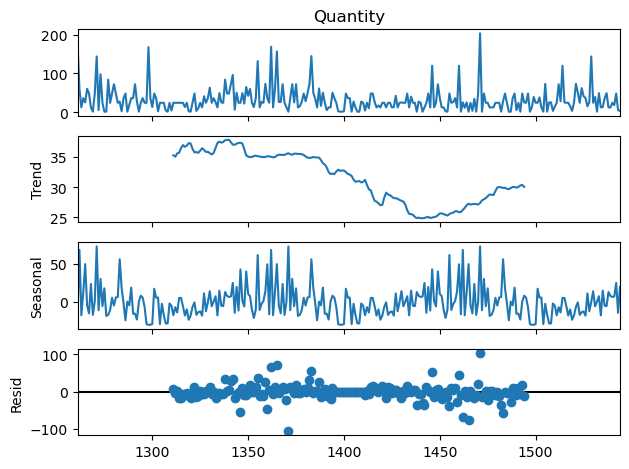

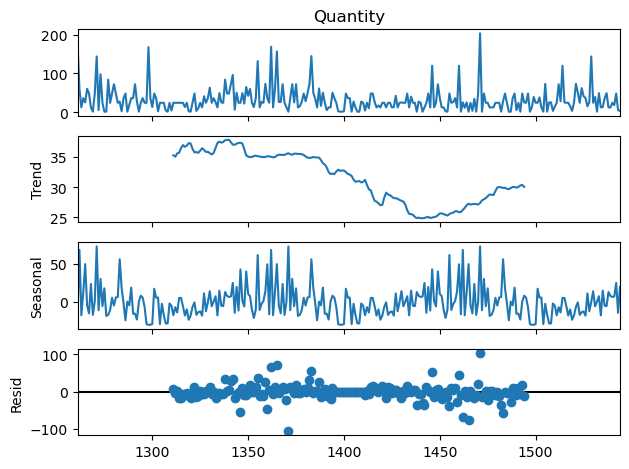

In [131]:
q1_df=p1_df["Quantity"]
result = seasonal_decompose(q1_df, model='additive',period=100)
result.plot()

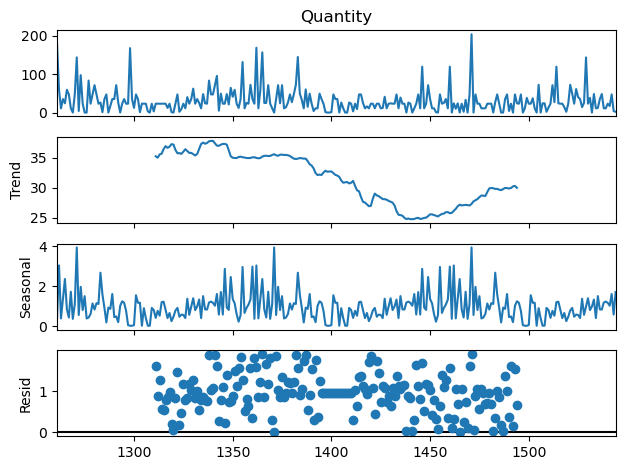

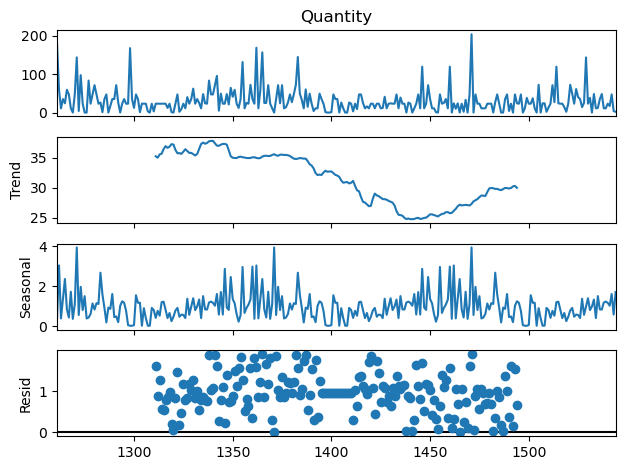

In [132]:
q1_df=p1_df["Quantity"]
result = seasonal_decompose(q1_df, model='multiplicative',period=100)
result.plot()

### Seasonality Analysis(Monthly)

In [41]:
monthly_df.head()

,Description,Date,DayofWeek,Month,Quantity,Price,NumberOfSaleDays
1261,10 COLOUR SPACEBOY PEN,2010-05-06,Thursday,5,180,0.806667,284
1262,10 COLOUR SPACEBOY PEN,2010-05-07,Friday,5,60,0.850000,284
1263,10 COLOUR SPACEBOY PEN,2010-05-09,Sunday,5,12,0.850000,284
1264,10 COLOUR SPACEBOY PEN,2010-05-10,Monday,5,36,0.850000,284
1265,10 COLOUR SPACEBOY PEN,2010-05-11,Tuesday,5,25,0.850000,284


In [123]:
p2_df=monthly_df[monthly_df['Description']=='10 COLOUR SPACEBOY PEN']
p2_df

,Month,Description,DayofWeek,Quantity,Price
604,1,10 COLOUR SPACEBOY PEN,Monday,2,1.630000
605,1,10 COLOUR SPACEBOY PEN,Sunday,36,0.850000
606,1,10 COLOUR SPACEBOY PEN,Thursday,96,0.850000
607,1,10 COLOUR SPACEBOY PEN,Tuesday,1,1.630000
608,1,10 COLOUR SPACEBOY PEN,Wednesday,29,1.380000
...,...,...,...,...,...
668,12,10 COLOUR SPACEBOY PEN,Monday,92,1.490000
669,12,10 COLOUR SPACEBOY PEN,Sunday,26,0.850000
670,12,10 COLOUR SPACEBOY PEN,Thursday,127,1.138182
671,12,10 COLOUR SPACEBOY PEN,Tuesday,67,1.538333


In [124]:
p2_df.asfreq('M')

,Month,Description,DayofWeek,Quantity,Price


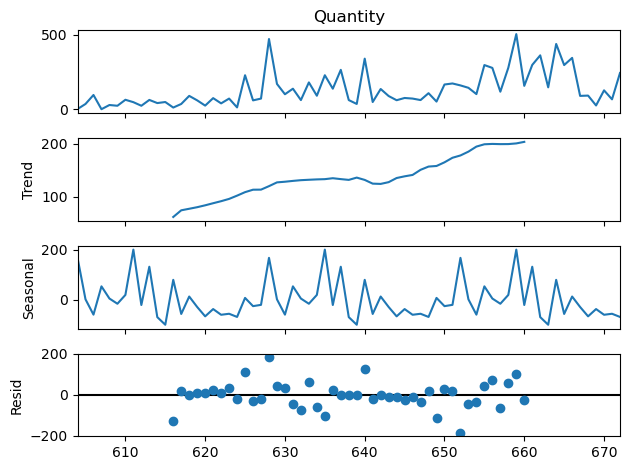

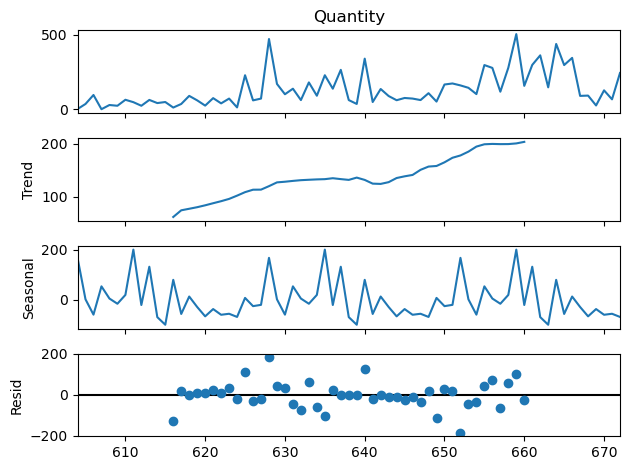

In [126]:
q2_df=p2_df["Quantity"]
result = seasonal_decompose(q2_df, model='additive',period=24)
result.plot()

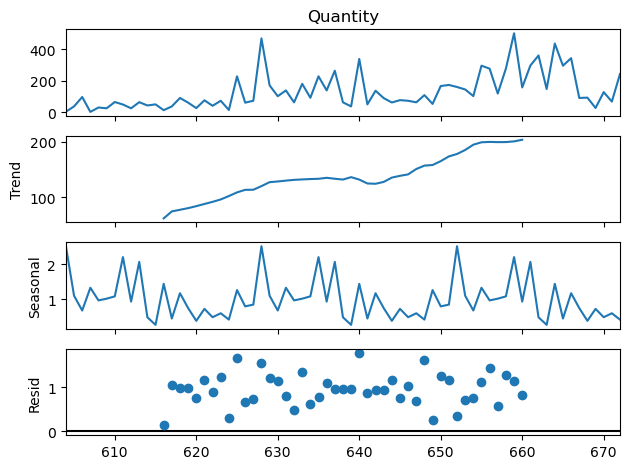

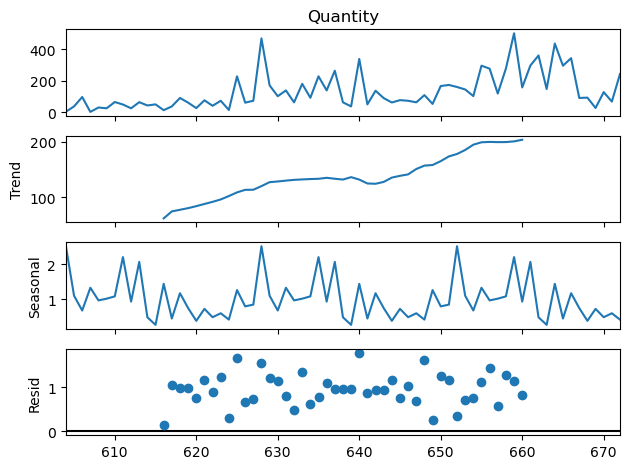

In [128]:
q2_df=p2_df["Quantity"]
result = seasonal_decompose(q2_df, model='multiplicative',period=24)
result.plot()

In [41]:
daily_df.head()

,Description,Date,DayofWeek,Month,Quantity,Price,NumberOfSaleDays
1261,10 COLOUR SPACEBOY PEN,2010-05-06,Thursday,5,180,0.806667,284
1262,10 COLOUR SPACEBOY PEN,2010-05-07,Friday,5,60,0.850000,284
1263,10 COLOUR SPACEBOY PEN,2010-05-09,Sunday,5,12,0.850000,284
1264,10 COLOUR SPACEBOY PEN,2010-05-10,Monday,5,36,0.850000,284
1265,10 COLOUR SPACEBOY PEN,2010-05-11,Tuesday,5,25,0.850000,284


In [44]:
p1_df=daily_df[daily_df['Description']=='12 PENCILS SMALL TUBE SKULL']
p1_df

,Description,Date,DayofWeek,Month,Quantity,Price,NumberOfSaleDays
3367,12 PENCILS SMALL TUBE SKULL,2009-12-01,Tuesday,12,4,0.975000,405
3368,12 PENCILS SMALL TUBE SKULL,2009-12-02,Wednesday,12,39,0.812500,405
3369,12 PENCILS SMALL TUBE SKULL,2009-12-03,Thursday,12,33,0.780000,405
3370,12 PENCILS SMALL TUBE SKULL,2009-12-04,Friday,12,37,0.758333,405
3371,12 PENCILS SMALL TUBE SKULL,2009-12-06,Sunday,12,1,0.650000,405
...,...,...,...,...,...,...,...
3767,12 PENCILS SMALL TUBE SKULL,2011-11-13,Sunday,11,37,0.650000,405
3768,12 PENCILS SMALL TUBE SKULL,2011-11-22,Tuesday,11,1,0.650000,405
3769,12 PENCILS SMALL TUBE SKULL,2011-12-07,Wednesday,12,8,0.650000,405
3770,12 PENCILS SMALL TUBE SKULL,2011-12-08,Thursday,12,3,0.650000,405


In [48]:
p1_df.asfreq('D')

,Description,Date,DayofWeek,Month,Quantity,Price,NumberOfSaleDays
1970-01-01 00:00:00.000003367,NaN,NaN,NaN,NaN,NaN,NaN,NaN


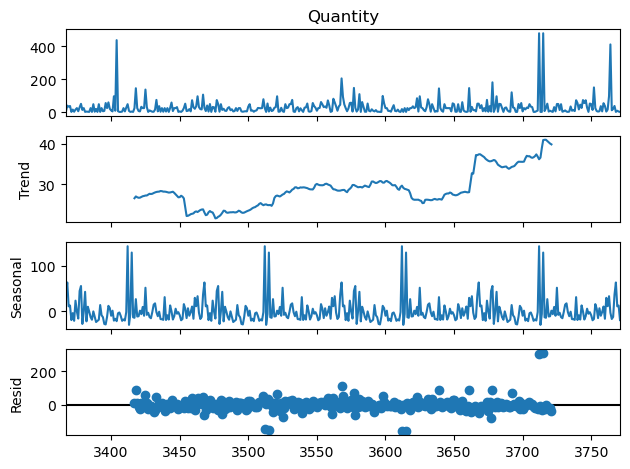

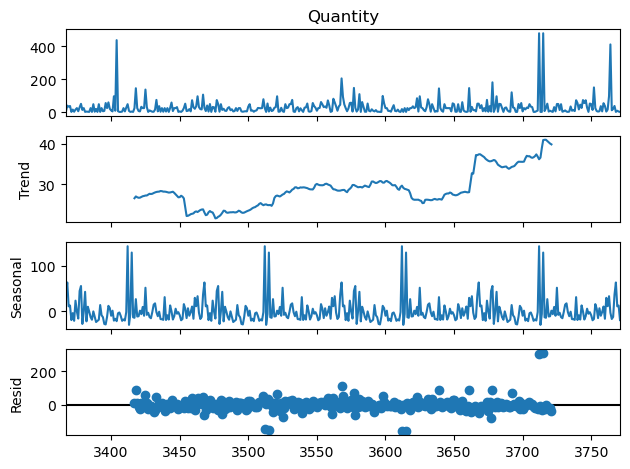

In [49]:
q1_df=p1_df["Quantity"]
result = seasonal_decompose(q1_df, model='additive',period=100)
result.plot()

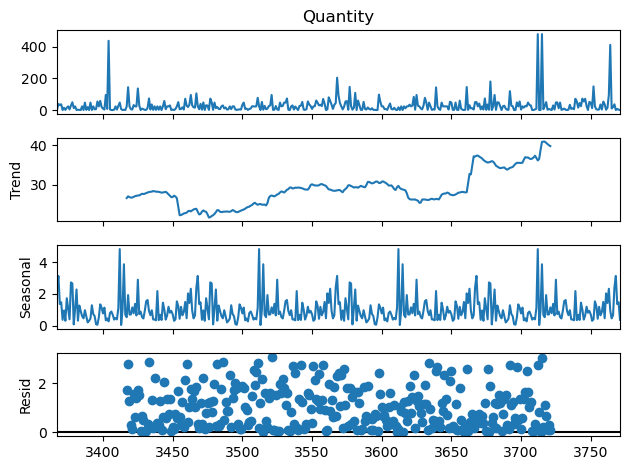

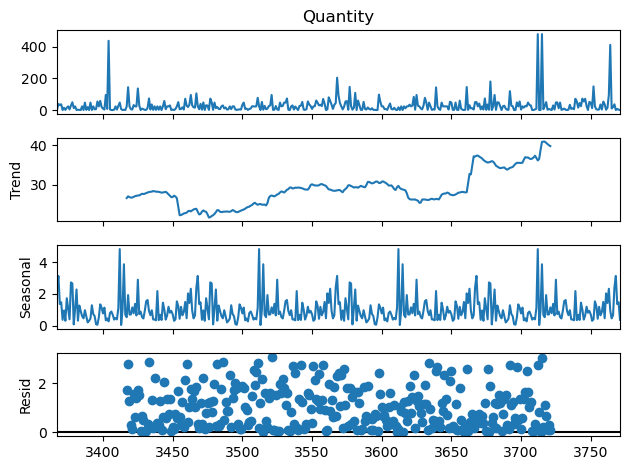

In [50]:
q1_df=p1_df["Quantity"]
result = seasonal_decompose(q1_df, model='multiplicative',period=100)
result.plot()